<a href="https://colab.research.google.com/github/msbeigi/NLP-analysis/blob/main/%5Csentence_classification%5Ctransformers%5Csentence_level_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

requirements

In [2]:
!pip install --upgrade transformers==4.30

# !pip install transformers[torch,accelerate]
# !pip install transformers[torch,accelerate]
# !pip install accelerate==0.20.1
!pip install accelerate -U
!pip install --upgrade sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.5 MB/s eta 0:00:00


In [3]:
from transformers import pipeline
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

#
from matplotlib import pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data processing utilities**

In [4]:
def data_preparation(data ):
    # Encode the 'label_sexist' column to numerical values
    label_encoder = LabelEncoder()
    data['label'] = label_encoder.fit_transform(data['label_sexist'])

    # Extract tokens and targets based on provided information
    data['token'] = data['token'].fillna('none')
    data['target'] = data['target'].fillna('none')
    return data

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stopwords.words('english') and word.isalnum()]

    return ' '.join(tokens)

def remove_noises(text):
    # Convert to lowercase
    text = text.lower()
    noise_pattern = r'\[url\]|\[user\]|\[username\]|\#\w+'
    cleaned_text = re.sub(noise_pattern, '', text)

    return cleaned_text

def data_cleansing(data):
    data['text'] = data['text'].apply(remove_noises)

    return data

def data_preprocess(data):
    # data cleaning
    data = data_cleansing(data)

    # Apply preprocessing to the 'text' column
    data['text_token'] = data['text'].apply(preprocess_text)
    data=data_preparation(data )
    return data


**Data loading**

In [5]:
df=pd.read_csv("/content/drive/MyDrive/Uni/Aston/Dissertation/edos_labelled_aggregated.csv",sep=",")
df.head()

,rewire_id,text,label_sexist,label_category,label_vector,split,token,target,keyword
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",not sexist,none,none,dev,NaN,NaN,NaN
1,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,none,none,train,NaN,NaN,NaN
2,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,none,none,train,NaN,NaN,NaN
3,sexism2022_english-13021,woman?,not sexist,none,none,train,NaN,NaN,NaN
4,sexism2022_english-966,I bet she wished she had a gun,not sexist,none,none,dev,NaN,NaN,NaN


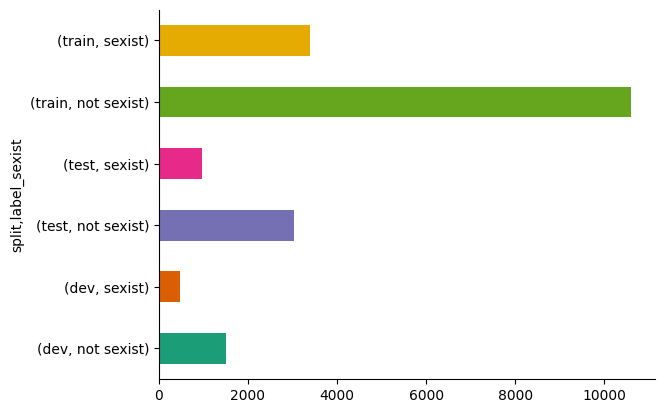

In [6]:

df.groupby(['split','label_sexist']).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

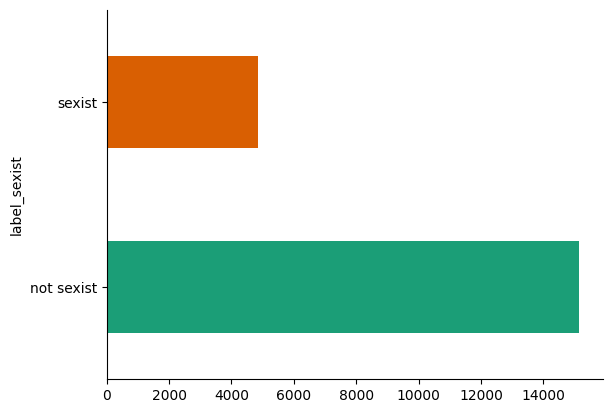

In [7]:

df.groupby('label_sexist').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:

# preprocess
data=data_preprocess(df)
# feature extraction
# df_=extract_feature(data)

In [9]:
df_train=data[data['split']=='train']#[['rewire_id','label_sexist','text_token']]
df_test=data[data['split']=='test']#[['rewire_id','label_sexist','text_token']]
df_evaluate=data[data['split']=='dev']#[['rewire_id','label_sexist','text_token']]
df_evaluate.head(5)

,rewire_id,text,label_sexist,label_category,label_vector,split,token,target,keyword,text_token,label
0,sexism2022_english-9609,"in nigeria, if you rape a woman, the men rape ...",not sexist,none,none,dev,none,none,NaN,nigeria rape woman men rape back nigeria rape ...,0
4,sexism2022_english-966,i bet she wished she had a gun,not sexist,none,none,dev,none,none,NaN,bet wished gun,0
9,sexism2022_english-3553,i agree with that but at the same time i know ...,sexist,2. derogation,2.1 descriptive attacks,dev,"I can't love a woman, she begins to hit the wall",women,NaN,agree time know well enough say love woman min...,1
15,sexism2022_english-13328,democrats from minnesota (leftist muzzie shith...,sexist,2. derogation,2.2 aggressive and emotive attacks,dev,"democrats are the dumbest anti-americans , Klo...","Klobuchar, this stupid woman","dumbest, dumb bitch, Fuck, stupid",democrats minnesota leftist muzzie shithole du...,1
29,sexism2022_english-81,texas jury sentences jordanian immigrant to de...,not sexist,none,none,dev,none,none,NaN,texas jury sentences jordanian immigrant death...,0


**Load "distilbert-base-uncased" model**

In [7]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)


(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.

**Sample training with "bert-base-uncased"**

In [10]:
from transformers import BertTokenizerFast
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
# from transformers import BertTokenizerFast, BertForSequenceClassification
# from transformers import Trainer, TrainingArguments
# from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import f1_score, classification_report



model_name = "bert-base-uncased"
max_length = 255
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)



(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)base-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
train_texts=df_train['text'].tolist()
train_labels = df_train['label'].astype(int).tolist()

valid_texts=df_evaluate['text'].tolist()
valid_labels = df_evaluate['label'].astype(int).tolist()



In [13]:

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [14]:

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
train_dataset = CustomDataset(train_encodings, train_labels)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_encodings = tokenizer(valid_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
test_dataset = CustomDataset(test_encodings, valid_labels)

In [20]:

model=BertForSequenceClassification.from_pretrained(model_name)
training_args = TrainingArguments(
    output_dir='/content/output',
    num_train_epochs=10,
    per_device_train_batch_size=16,  # batch size per device during training
    weight_decay=0.01,               # strength of weight decay
    load_best_model_at_end=True,
    logging_steps=200,
    evaluation_strategy="steps",
    save_steps=400,  # Set this to a multiple of evaluation_steps
    # no_deprecation_warning=True
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [21]:

trainer = Trainer( model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,)
trainer.train()



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
200,0.457600,0.419785
400,0.421200,0.352295
600,0.301600,0.421652
800,0.273600,0.365451
1000,0.220400,0.639786
1200,0.146600,0.479470
1400,0.141800,0.565578
1600,0.064900,0.747661
1800,0.075500,0.799349
2000,0.054200,0.824558


TrainOutput(global_step=4640, training_loss=0.09902979127923729, metrics={'train_runtime': 4243.1258, 'train_samples_per_second': 17.485, 'train_steps_per_second': 1.094, 'total_flos': 3393161364349800.0, 'train_loss': 0.09902979127923729, 'epoch': 10.0})

In [24]:

test_texts_2=df_test['text'].tolist()
test_labels_2 = df_test['label'].astype(int).tolist()


test_encodings_2 = tokenizer(test_texts_2, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
test_dataset_2 = CustomDataset(test_encodings_2, test_labels_2)

In [24]:
predictions = trainer.predict(test_dataset_2).predictions
predicted_labels = predictions.argmax(axis=1)
f1_macro = f1_score(test_labels_2, predicted_labels, average='macro')

print("F1 Macro:", f1_macro)
print(classification_report(test_labels_2, predicted_labels))


F1 Macro: 0.7769499146022801
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1579
           1       0.84      0.53      0.65       563

    accuracy                           0.85      2142
   macro avg       0.85      0.75      0.78      2142
weighted avg       0.85      0.85      0.84      2142



In [23]:

file_content = "Hello, this is some sample content for the file."

con_path = '/content/drive/My Drive/ML/NLPResults/'
file_path =con_path+ 'sample2.txt'

with open(file_path, 'w') as file:
    file.write(file_content)

trainer.save_model(con_path)

In [16]:
con_path_xl = '/content/drive/My Drive/ML/NLPResults/XL/'


**Load "xlnet-large-cased" and "roberta-large" models**

In [17]:
from transformers import XLNetForSequenceClassification, XLNetTokenizer
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import XLNetTokenizer, XLNetForSequenceClassification

# XLNet
xlnet_model_name = "xlnet-large-cased"
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model_name)
xlnet_model = XLNetForSequenceClassification.from_pretrained(xlnet_model_name)

# Roberta
roberta_model_name = "roberta-large"
roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
roberta_model = RobertaForSequenceClassification.from_pretrained(roberta_model_name)


(…)et-large-cased/resolve/main/spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

(…)net-large-cased/resolve/main/config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-large-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-large-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

(…)co/roberta-large/resolve/main/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

(…)co/roberta-large/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)o/roberta-large/resolve/main/config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should 

In [18]:
xl_tokenizer = BertTokenizerFast.from_pretrained(xlnet_model_name, do_lower_case=True)


(…)-large-cased/resolve/main/tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
xl_model=BertForSequenceClassification.from_pretrained(xlnet_model_name)


xl_trainer = Trainer(
    model=xl_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,  # Use the test_dataset for evaluation
)

# Train the model
xl_trainer.train()


You are using a model of type xlnet to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlnet-large-cased were not used when initializing BertForSequenceClassification: ['transformer.layer.0.rel_attn.r_w_bias', 'transformer.layer.8.ff.layer_norm.bias', 'transformer.layer.1.rel_attn.r_r_bias', 'transformer.layer.18.ff.layer_1.bias', 'transformer.layer.2.ff.layer_norm.weight', 'transformer.layer.18.ff.layer_norm.bias', 'transformer.layer.10.ff.layer_2.weight', 'transformer.layer.22.ff.layer_norm.weight', 'transformer.layer.10.rel_attn.r_s_bias', 'transformer.layer.20.rel_attn.layer_norm.weight', 'transformer.layer.17.rel_attn.seg_embed', 'transformer.layer.18.rel_attn.r_s_bias', 'transformer.layer.3.ff.layer_2.bias', 'transformer.layer.15.rel_attn.layer_norm.bias', 'transformer.layer.2.rel_attn.r_s_bias', 'transformer.layer.9.rel_attn.o', 'transformer.layer.13.rel_attn.o', 'transformer.l

Step,Training Loss,Validation Loss
200,0.580800,0.560470
400,0.566300,0.555656
600,0.573600,0.576113
800,0.575200,0.562054
1000,0.565400,0.555085
1200,0.556500,0.566116
1400,0.572200,0.565165
1600,0.567800,0.560083
1800,0.557800,0.558704
2000,0.580200,0.566740


TrainOutput(global_step=8750, training_loss=0.5621246250697545, metrics={'train_runtime': 8744.6941, 'train_samples_per_second': 16.01, 'train_steps_per_second': 1.001, 'total_flos': 6403054198800000.0, 'train_loss': 0.5621246250697545, 'epoch': 10.0})

**Save trained model**

In [22]:
con_path_xl = '/content/drive/My Drive/ML/NLPResults/XL/'
xl_trainer.save_model(con_path_xl)


In [25]:
xl_predictions = xl_trainer.predict(test_dataset_2).predictions
xl_predicted_labels = xl_predictions.argmax(axis=1)
f1_macro = f1_score(test_labels_2, xl_predicted_labels, average='macro')

print("F1 Macro:", f1_macro)
print(classification_report(test_labels_2, xl_predicted_labels))


F1 Macro: 0.4310099573257468
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3030
           1       0.00      0.00      0.00       970

    accuracy                           0.76      4000
   macro avg       0.38      0.50      0.43      4000
weighted avg       0.57      0.76      0.65      4000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# !pip install optuna
!git init


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [28]:
!git add .

^C
